In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


In [2]:
import utils_generic as generic
import multitask_simple as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,tasks,model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,tasks,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset(md_data,tasks,model_conf) 
md_dataset = mt.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0506196127951353 	 Validation loss: 2.010968351768235 	 
  1%|          | 574/57400 [02:14<3:22:56,  4.67it/s]
Epoch 2 	 Training loss: 1.9908825358447297 	 Validation loss: 1.9882923101974745 	 
  2%|▏         | 1148/57400 [04:21<3:30:24,  4.46it/s]
Epoch 3 	 Training loss: 1.978911323414447 	 Validation loss: 1.973922470868644 	 
  3%|▎         | 1722/57400 [06:30<3:19:18,  4.66it/s]
Epoch 4 	 Training loss: 1.972869459552632 	 Validation loss: 1.9766545093665688 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [08:39<3:25:26,  4.47it/s]
Epoch 5 	 Training loss: 1.968968317899139 	 Validation loss: 1.9800002191026331 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [10:49<3:49:35,  3.96it/s]
Epoch 6 	 Training loss: 1.964999890493599 	 Validation loss: 1.9779508012836262 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [12:58<3:12:11,  4.68it/s]
Epoch 7 	 Training loss: 1.9611735786295104 	 Validation loss: 1.971282936758914

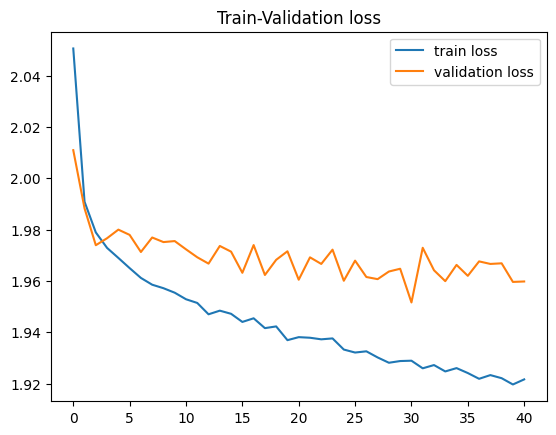

In [11]:
model = mt.MultiTaskSimple(model_conf).to(device)
save_path='m1_distilbert_multi-adamw'
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [12]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.6616161616161617, 'as': 0.7196870925684485, 'about': 0.8099489795918368}
Accuracy evaluando en etiquetas female
{'to': 0.6509186351706037, 'as': 0.7601078167115903, 'about': 0.8075}
Accuracy evaluando en etiquetas male
{'to': 0.6715328467153284, 'as': 0.6818181818181818, 'about': 0.8125}
